### UpGrad Assignment - Advanced Regression
##### Problem Statement
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:

- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

Also, **determine the optimal value of lambda for ridge and lasso regression**.

In [50]:
%pip install -q numpy pandas matplotlib scikit-learn seaborn statsmodels jinja2

Note: you may need to restart the kernel to use updated packages.


In [51]:
import os
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [52]:
if os.name == 'nt':
  !curl.exe -o train.csv https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv
else:
  !wget -P . https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  4  449k    4 18968    0     0  12371      0  0:00:37  0:00:01  0:00:36 12381
 64  449k   64  288k    0     0   119k      0  0:00:03  0:00:02  0:00:01  120k
100  449k  100  449k    0     0   179k      0  0:00:02  0:00:02 --:--:--  179k


In [53]:
df_data = pd.read_csv('./train.csv', index_col='Id')
print(f"\nDataset has {df_data.shape[0]} records with {df_data.shape[1]-1} features or columns with 1 target variable 'SalePrice'.\n")
df_data.info()


Dataset has 1460 records with 79 features or columns with 1 target variable 'SalePrice'.

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQua

In [54]:
ORDINAL_CATEGORICAL_FEATURES = ['CentralAir', 'MSSubClass', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'PoolQC']
NOMINAL_CATEGORICAL_FEATURES = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']

NUMERICAL_FEATURES = [
    'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

print(f"Out of total {len(ORDINAL_CATEGORICAL_FEATURES) + len(NOMINAL_CATEGORICAL_FEATURES) + len(NUMERICAL_FEATURES)} features there are, \
      \n- {len(ORDINAL_CATEGORICAL_FEATURES)} Categorical Ordinal Featrues \
      \n- {len(NOMINAL_CATEGORICAL_FEATURES)} Categorical Nominal Featrues \
      \n- {len(NUMERICAL_FEATURES)} Numerical Featrues")

Out of total 79 features there are,       
- 21 Categorical Ordinal Featrues       
- 25 Categorical Nominal Featrues       
- 33 Numerical Featrues


In [55]:
# Few Nominal Categorical varibles OneHotEncoding is throwing error when read_csv loadded NA and None values as NaN. Hence, setting them to 'NA'
for feature in NOMINAL_CATEGORICAL_FEATURES:
    if df_data[feature].isna().sum() > 0:
        df_data.loc[df_data[feature].isna(), feature] = 'NA'

#### Data Quality Checks

- Identify missing values and treat them.

In [56]:
# Identify columns with null values in numeric features
for column in list(df_data[NUMERICAL_FEATURES].columns[df_data[NUMERICAL_FEATURES].isna().any()]):
  print(f"{column}: {df_data[column].isna().sum()}")

LotFrontage: 259
MasVnrArea: 8
GarageYrBlt: 81


In [57]:
# Missing LotFrontage (Linear feet of street connected to property) replaced with ZERO, Could have been replaced with MEDIAN.
df_data.loc[df_data['LotFrontage'].isna(), 'LotFrontage'] = 0

In [58]:
# GarageYrBlt is NaN when ther is 'No Garage'
df_data[['GarageYrBlt', 'GarageType']][df_data['GarageType'] == 'NA'].head(5)
# Lets set GarageYrBlt to ZERO for these records.
df_data.loc[df_data['GarageType'] == 'NA', 'GarageYrBlt'] = 0

In [59]:
# Few MasVnrArea is NaN when there is Masonry veneer type has been set to None (in our case NA)
df_data[['MasVnrArea', 'MasVnrType']][df_data['MasVnrArea'].isna()]
# Lets set MasVnrArea to ZERO for these records.
df_data.loc[df_data['MasVnrArea'].isna(), 'MasVnrArea'] = 0

#### Univariate Analysis: Numerical features

When dealing with numerical variables, we have to check their properties like:

- Mean
- Median
- Standard Deviation
- Kurtosis/skewness
- distribution/range

In [60]:
df_data[df_data['LotFrontage'] > 300]
df_data[df_data['LotArea'] > 100000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
250,50,RL,0.0,159000,Pave,NA,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697,Unf,0,747,1444,GasA,Gd,Y,SBrkr,1444,700,0,2144,0,1,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.0,Fin,2,389,TA,TA,Y,0,98,0,0,0,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
314,20,RL,150.0,215245,Pave,NA,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,NA,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,TA,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.0,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NA,0,6,2009,WD,Normal,375000
336,190,RL,0.0,164660,Grvl,NA,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,NA,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249,BLQ,147,103,1499,GasA,Ex,Y,SBrkr,1619,167,0,1786,2,0,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.0,Fin,2,529,TA,TA,Y,670,0,0,0,0,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
707,20,RL,0.0,115149,Pave,NA,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219,Unf,0,424,1643,GasA,TA,Y,SBrkr,1824,0,0,1824,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2,739,TA,TA,Y,380,48,0,0,0,0,NaN,NaN,NA,0,6,2007,WD,Normal,302000


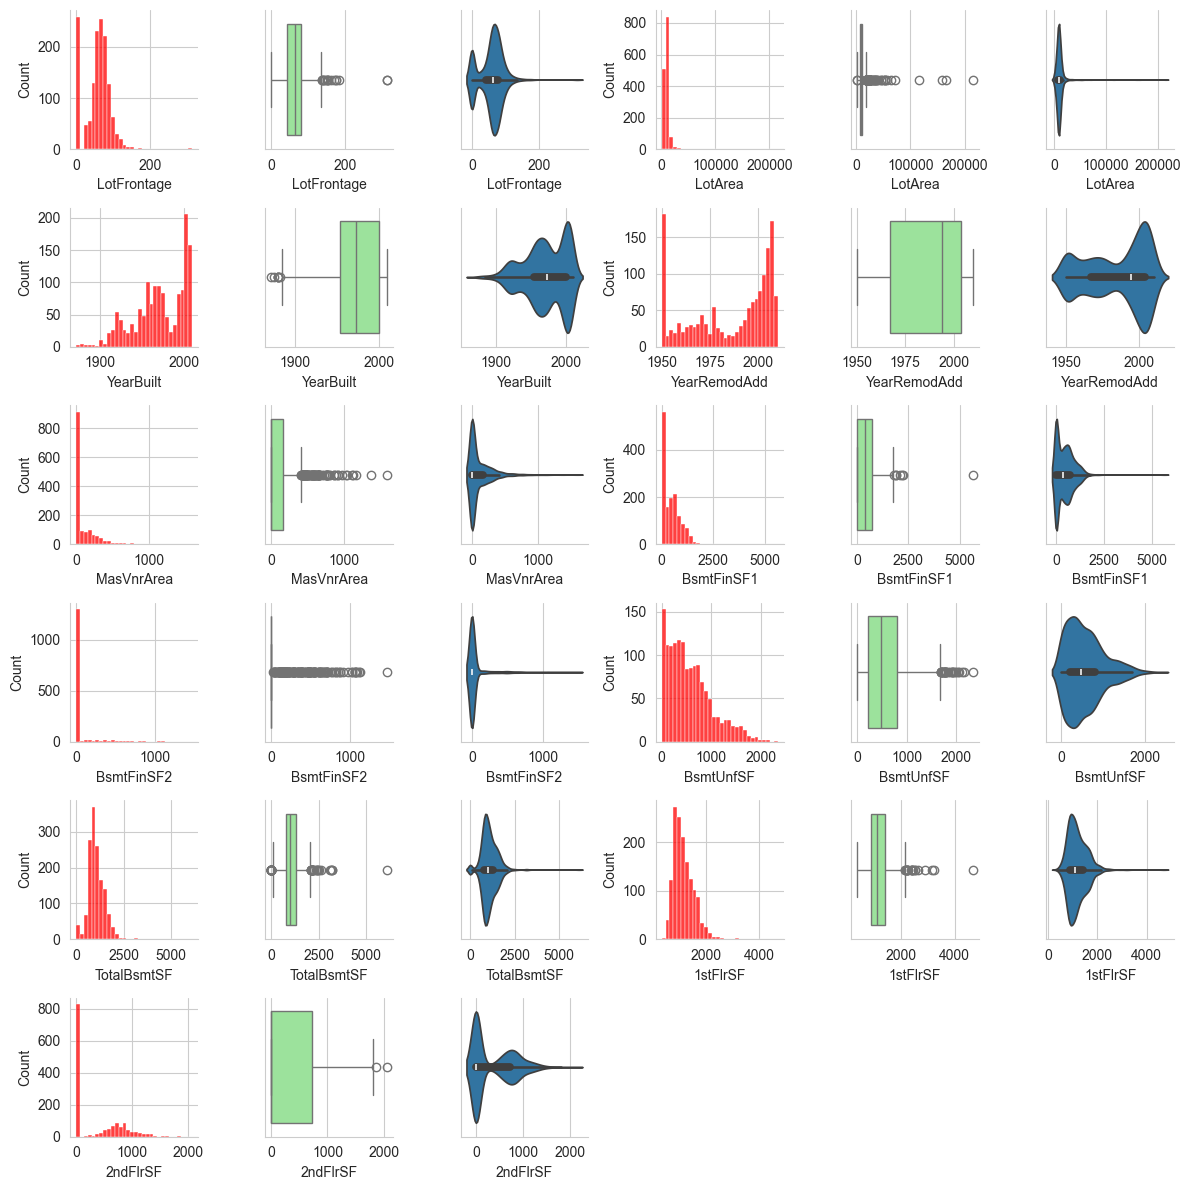

In [61]:
sns.set_style('whitegrid')

num_plots_in_a_row = 6   # No. of plots in every row
num_of_plot_rows = math.ceil(len(NUMERICAL_FEATURES)/num_plots_in_a_row)   # No. of plots in y direction

grid = sns.FacetGrid(pd.DataFrame(NUMERICAL_FEATURES), col=0, col_wrap=6, height=2, sharex=False, sharey=False)
for i, feature in enumerate(NUMERICAL_FEATURES):
    # If not enough features, move on.
    if i*3 >= len(grid.axes):
        break
    axes = sns.histplot(df_data, x=feature, kde = False, color ='red', bins=30, ax=grid.axes[i*3 + 0])
    axes.set_title(None)
    axes = sns.boxplot(df_data, x=feature, color ='lightgreen', ax=grid.axes[i*3 + 1])
    axes.set_title(None)
    axes = sns.violinplot(data=df_data, x=feature, ax=grid.axes[i*3 + 2])
    axes.set_title(None)

grid.tight_layout()
plt.show()


#### Summary of Univariate Analysis: Numerical Features

- `LotArea`, `LotFrontage`, `1stFlrSF` has few outliers. We can remove these records, for now let them include as dataset is small.
- `YearBuilt` indicates that data is of last century.  

##### Univariate Analysis: Categorical Features

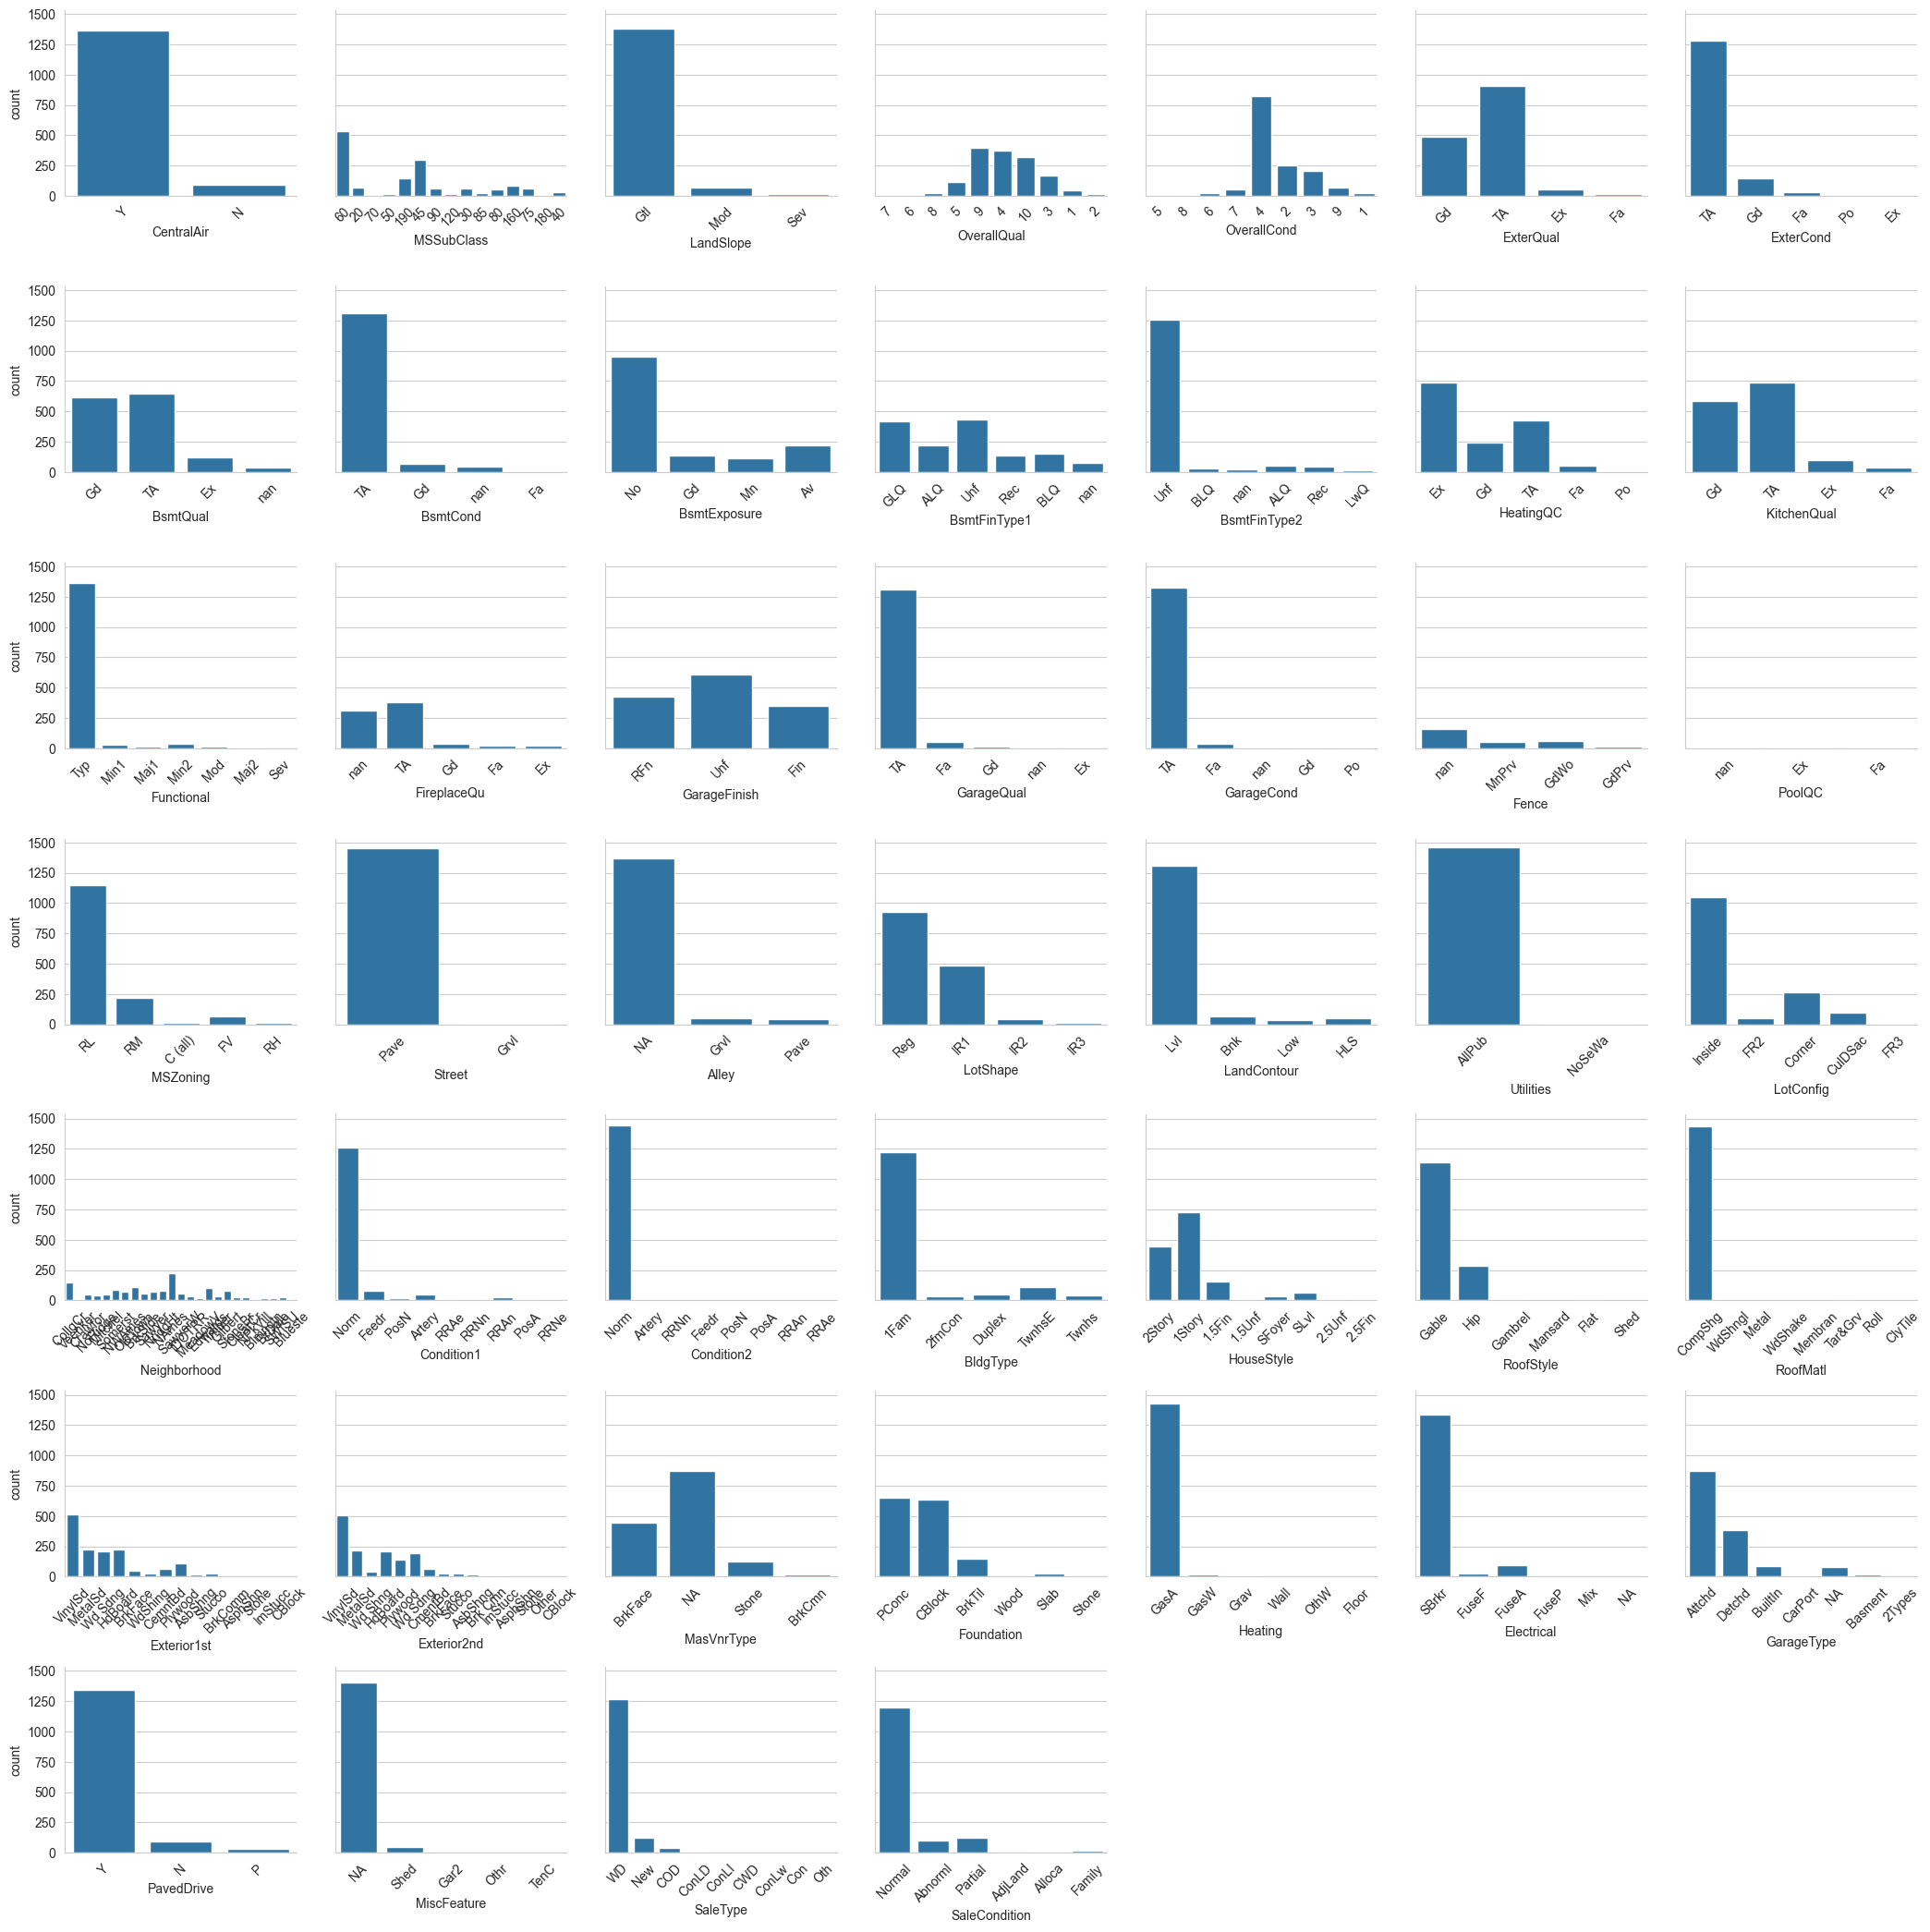

In [62]:
import warnings
warnings.filterwarnings('ignore')

num_plots_in_a_row = 7   # No. of plots in every row
num_of_plot_rows = math.ceil(len(list(ORDINAL_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES))/num_plots_in_a_row)   # No. of plots in y direction

grid = sns.FacetGrid(pd.DataFrame(list(ORDINAL_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES)), col=0, col_wrap=7, height=3, sharey=True, sharex=False, margin_titles=False)
for axs, feature in zip(grid.axes, list(ORDINAL_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES)):
    axes = sns.countplot(df_data, x=feature, ax=axs)
    axes.set_title(None)
    axes.set_xticklabels(labels=df_data[feature].unique(), rotation=45)

grid.tight_layout()
plt.show()

#### Summary of Univariate Analysis: Categorical Features

- `OverallCond` & `OverallQual` is a kind of normal distribution could be co-related.
- `ExterQual` & `ExterCond` are correlated.

#### Bivariate Analysis

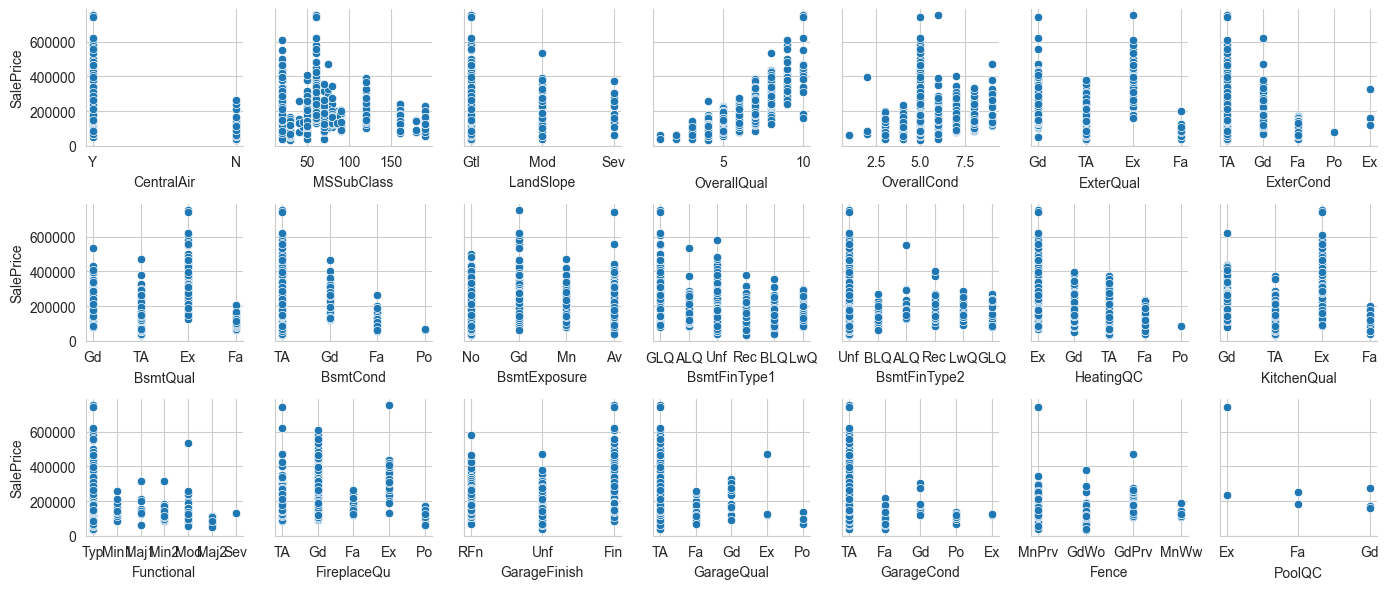

In [63]:
num_plots_in_a_row = 7   # No. of plots in every row
num_of_plot_rows = math.ceil(len(ORDINAL_CATEGORICAL_FEATURES)/num_plots_in_a_row)   # No. of plots in y direction

grid = sns.FacetGrid(pd.DataFrame(ORDINAL_CATEGORICAL_FEATURES), col=0, col_wrap=7, height=2, sharex=False)
for ax, feature in zip(grid.axes, ORDINAL_CATEGORICAL_FEATURES):
    axes = sns.scatterplot(data=df_data, x=feature, y='SalePrice', ax=ax)
    axes.set_title(None)
    
grid.tight_layout()
plt.show()

#### Bivariate Analysis Summary

- Good conditions and quality has postive impact on SalePrice. 
- Land slope has not much significance on SalePrice.

#### Multivariate Analysis

*Multicollinearity* Checks - Draw Heatmap to check for multicollinearity and relationship between two variables


<Axes: >

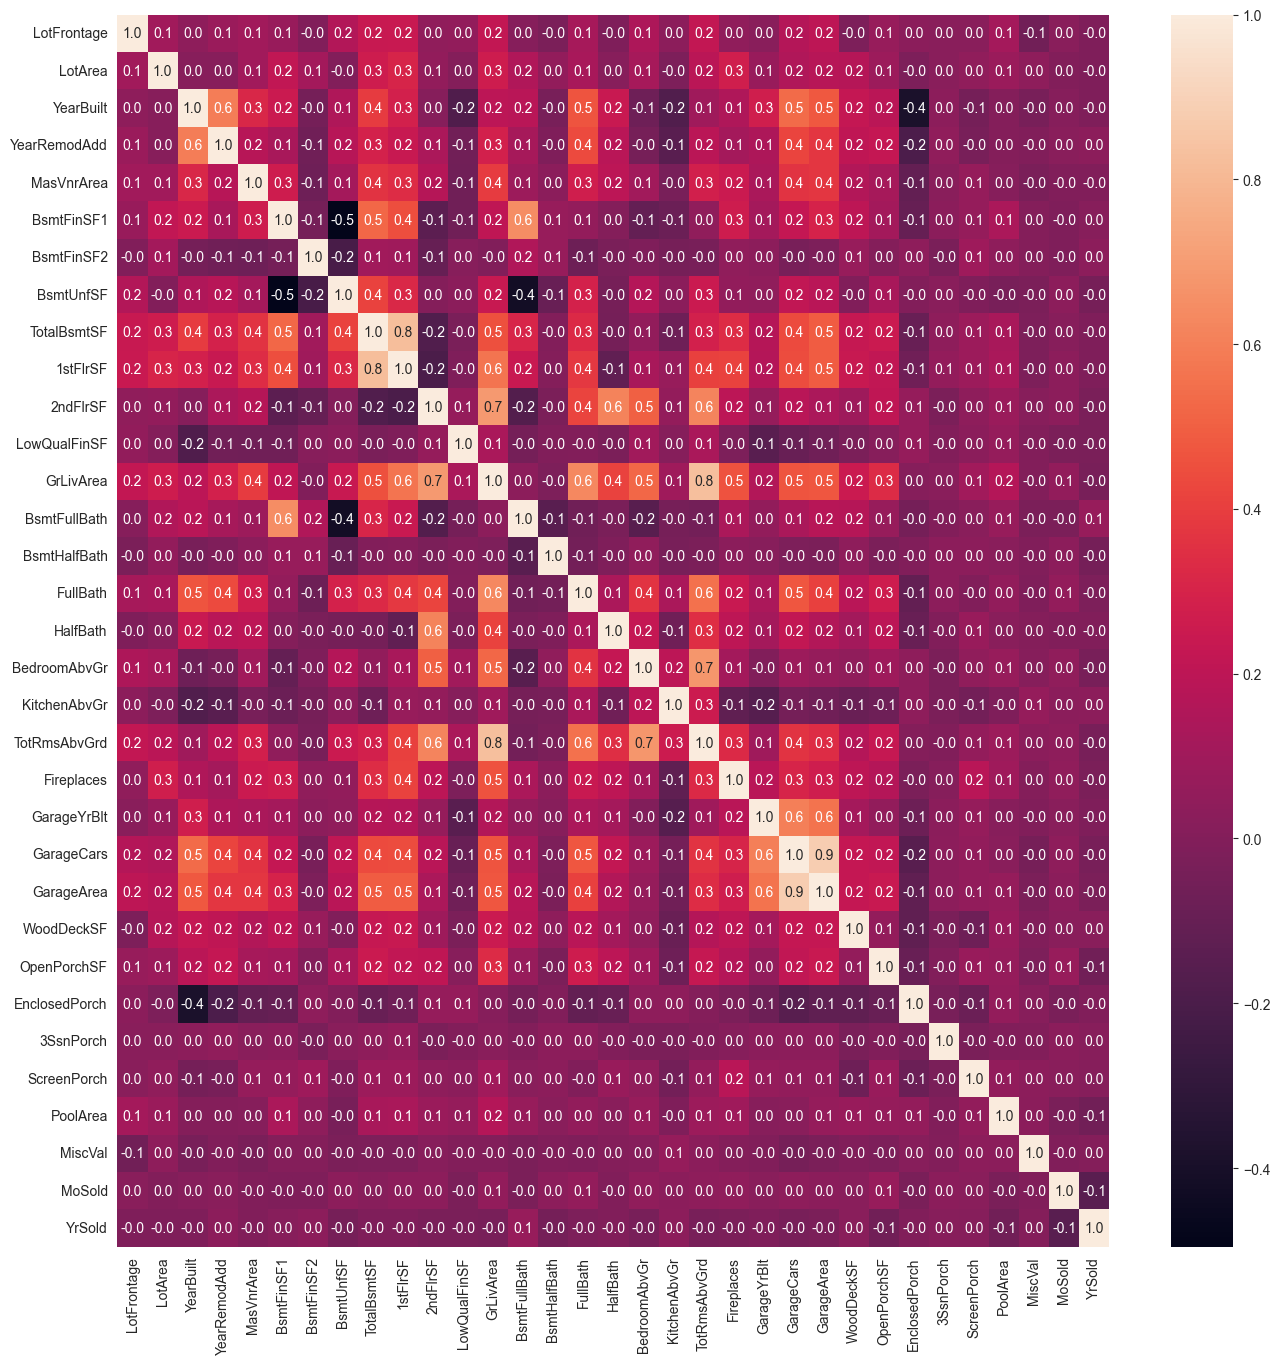

In [64]:
plt.figure(figsize=(16, 16))
sns.heatmap(df_data[NUMERICAL_FEATURES].corr(), annot=True, fmt=".1f")

#### Multivariate Analysis Summary

- `GarageArea` and `GarageCars` are highly correlated (0.9). One of them can be excluded.
- `YearBuilt` and `GarageYrBlt` are highly correlated (0.8). I guess `GarageYrBlt` can be removed.
- GrLivArea: Above grade (ground) living area square feet (`GrLivArea`) and `TotRmsAbvGrd`: Total rooms above grade (does not include bathrooms) are correlated (0.8)

#### Feature Engineering

May be we can introduce some RATIOs such as,

- Ratio of Lot Area to built up area such as Ground Living Area. But, it is unclears which areas should be considered.

As we have many features, lets try with provided features and later revisit building new features.

#### Scaling Numerical Features

There are two common ways of rescaling:
- Min-Max scaling
- Standardisation (mean-0, sigma-1)

We will be using standardization here.

#### Encoding Category Features
- Encode Categorical Variable through One-hot Encoding
- One hot encoding: One hot encoding utilises N binary variables for N categories in a variable. 

In [65]:
# Map ordinal category features to ordinal values.
ordinal_values_by_feature = {
   'CentralAir': {'Y': 1, 'N': 0},
   'LandSlope': {'Gtl':2, 'Mod':1, 'Sev':0},
   'ExterQual' : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'BsmtQual': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
   'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
   'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,'NA': 0},
   'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,'NA': 0},
   'HeatingQC':  {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
   'KitchenQual':  {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
   'Functional': {'Typ':7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0},
   'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
   'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
   'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NA': 0},
   'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0}
}

for ordinal_category_feature in ordinal_values_by_feature:
   df_data[ordinal_category_feature] = df_data[ordinal_category_feature].map(ordinal_values_by_feature[ordinal_category_feature])

In [66]:
y = df_data['SalePrice']
df_data.drop('SalePrice', axis=1, inplace=True)

# Should we scale 'SalePrice'?

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numerical_feature_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_feature_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

column_transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_feature_transformer, NUMERICAL_FEATURES + ORDINAL_CATEGORICAL_FEATURES),
         ('cat', categorical_feature_transformer, NOMINAL_CATEGORICAL_FEATURES)]
    )

In [68]:
column_transformer.set_output(transform='pandas')

# fit the column transformer to the training data
column_transformer.fit(df_data[NUMERICAL_FEATURES + ORDINAL_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES])

# apply the pipeline to the training and test data
X_transformed = column_transformer.transform(df_data)

print(f"Total columns after features are transformed (scaling & encoding): {len(X_transformed.columns)}")

Total columns after features are transformed (scaling & encoding): 231


In [69]:
from sklearn.model_selection import train_test_split

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=100)
del X_transformed

### Feature Elimination

Use RFE (Recursive feature elimination) to eliminate unimportant features

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=100) # running RFE
rfe = rfe.fit(X_train, y_train)

In [71]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('num__LotFrontage', False, 115),
 ('num__LotArea', False, 94),
 ('num__YearBuilt', False, 88),
 ('num__YearRemodAdd', False, 124),
 ('num__MasVnrArea', False, 93),
 ('num__BsmtFinSF1', True, 1),
 ('num__BsmtFinSF2', True, 1),
 ('num__BsmtUnfSF', True, 1),
 ('num__TotalBsmtSF', True, 1),
 ('num__1stFlrSF', True, 1),
 ('num__2ndFlrSF', True, 1),
 ('num__LowQualFinSF', True, 1),
 ('num__GrLivArea', True, 1),
 ('num__BsmtFullBath', False, 113),
 ('num__BsmtHalfBath', False, 127),
 ('num__FullBath', False, 119),
 ('num__HalfBath', False, 131),
 ('num__BedroomAbvGr', False, 92),
 ('num__KitchenAbvGr', False, 101),
 ('num__TotRmsAbvGrd', False, 104),
 ('num__Fireplaces', False, 105),
 ('num__GarageYrBlt', False, 86),
 ('num__GarageCars', False, 97),
 ('num__GarageArea', False, 120),
 ('num__WoodDeckSF', False, 126),
 ('num__OpenPorchSF', False, 106),
 ('num__EnclosedPorch', False, 122),
 ('num__3SsnPorch', False, 111),
 ('num__ScreenPorch', False, 112),
 ('num__PoolArea', False, 100),
 ('nu

In [72]:
col = X_train.columns[rfe.support_]
print(f"Important features list: {col}")
print(f"Unimportant features list: {X_train.columns[~rfe.support_]}")

Important features list: Index(['num__BsmtFinSF1', 'num__BsmtFinSF2', 'num__BsmtUnfSF',
       'num__TotalBsmtSF', 'num__1stFlrSF', 'num__2ndFlrSF',
       'num__LowQualFinSF', 'num__GrLivArea', 'cat__MSZoning_C (all)',
       'cat__MSZoning_FV', 'cat__MSZoning_RH', 'cat__MSZoning_RL',
       'cat__MSZoning_RM', 'cat__Street_Grvl', 'cat__Street_Pave',
       'cat__LotShape_IR1', 'cat__LotShape_IR2', 'cat__LotShape_IR3',
       'cat__LotShape_Reg', 'cat__LandContour_Bnk', 'cat__LandContour_HLS',
       'cat__LandContour_Low', 'cat__LandContour_Lvl', 'cat__Utilities_AllPub',
       'cat__Utilities_NoSeWa', 'cat__LotConfig_Corner',
       'cat__LotConfig_CulDSac', 'cat__LotConfig_FR2', 'cat__LotConfig_FR3',
       'cat__LotConfig_Inside', 'cat__Condition1_Artery',
       'cat__Condition1_Feedr', 'cat__Condition1_Norm', 'cat__Condition1_PosA',
       'cat__Condition1_PosN', 'cat__Condition1_RRAe', 'cat__Condition1_RRAn',
       'cat__Condition1_RRNe', 'cat__Condition1_RRNn', 'cat__BldgType

Not eliminating any features for now using RFE.

#### Building model using statsmodel, for the detailed statistics

In [73]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [74]:
lm = sm.OLS(y_train,X_train_rfe).fit() # Running the linear model

In [75]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     58.15
Date:                Sun, 24 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:43:04   Log-Likelihood:                -13848.
No. Observations:                1168   AIC:                         2.786e+04
Df Residuals:                    1085   BIC:                         2.828e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -4

### Model Building and Evaluation

Lets predict sale price of house using linear regression.

In [76]:
pd.set_option('display.max_columns', 250)
X_train.describe()

,num__LotFrontage,num__LotArea,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,num__BsmtUnfSF,num__TotalBsmtSF,num__1stFlrSF,num__2ndFlrSF,num__LowQualFinSF,num__GrLivArea,num__BsmtFullBath,num__BsmtHalfBath,num__FullBath,num__HalfBath,num__BedroomAbvGr,num__KitchenAbvGr,num__TotRmsAbvGrd,num__Fireplaces,num__GarageYrBlt,num__GarageCars,num__GarageArea,num__WoodDeckSF,num__OpenPorchSF,num__EnclosedPorch,num__3SsnPorch,num__ScreenPorch,num__PoolArea,num__MiscVal,num__MoSold,num__YrSold,num__CentralAir,num__MSSubClass,num__LandSlope,num__OverallQual,num__OverallCond,num__ExterQual,num__ExterCond,num__BsmtQual,num__BsmtCond,num__BsmtExposure,num__BsmtFinType1,num__BsmtFinType2,num__HeatingQC,num__KitchenQual,num__Functional,num__FireplaceQu,num__GarageFinish,num__GarageQual,num__GarageCond,num__Fence,num__PoolQC,cat__MSZoning_C (all),cat__MSZoning_FV,cat__MSZoning_RH,cat__MSZoning_RL,cat__MSZoning_RM,cat__Street_Grvl,cat__Street_Pave,cat__Alley_Grvl,cat__Alley_NA,cat__Alley_Pave,cat__LotShape_IR1,cat__LotShape_IR2,cat__LotShape_IR3,cat__LotShape_Reg,cat__LandContour_Bnk,cat__LandContour_HLS,cat__LandContour_Low,cat__LandContour_Lvl,cat__Utilities_AllPub,cat__Utilities_NoSeWa,cat__LotConfig_Corner,cat__LotConfig_CulDSac,cat__LotConfig_FR2,cat__LotConfig_FR3,cat__LotConfig_Inside,cat__Neighborhood_Blmngtn,cat__Neighborhood_Blueste,cat__Neighborhood_BrDale,cat__Neighborhood_BrkSide,cat__Neighborhood_ClearCr,cat__Neighborhood_CollgCr,cat__Neighborhood_Crawfor,cat__Neighborhood_Edwards,cat__Neighborhood_Gilbert,cat__Neighborhood_IDOTRR,cat__Neighborhood_MeadowV,cat__Neighborhood_Mitchel,cat__Neighborhood_NAmes,cat__Neighborhood_NPkVill,cat__Neighborhood_NWAmes,cat__Neighborhood_NoRidge,cat__Neighborhood_NridgHt,cat__Neighborhood_OldTown,cat__Neighborhood_SWISU,cat__Neighborhood_Sawyer,cat__Neighborhood_SawyerW,cat__Neighborhood_Somerst,cat__Neighborhood_StoneBr,cat__Neighborhood_Timber,cat__Neighborhood_Veenker,cat__Condition1_Artery,cat__Condition1_Feedr,cat__Condition1_Norm,cat__Condition1_PosA,cat__Condition1_PosN,cat__Condition1_RRAe,cat__Condition1_RRAn,cat__Condition1_RRNe,cat__Condition1_RRNn,cat__Condition2_Artery,cat__Condition2_Feedr,cat__Condition2_Norm,cat__Condition2_PosA,cat__Condition2_PosN,cat__Condition2_RRAe,cat__Condition2_RRAn,cat__Condition2_RRNn,cat__BldgType_1Fam,cat__BldgType_2fmCon,cat__BldgType_Duplex,cat__BldgType_Twnhs,cat__BldgType_TwnhsE,cat__HouseStyle_1.5Fin,cat__HouseStyle_1.5Unf,cat__HouseStyle_1Story,cat__HouseStyle_2.5Fin,cat__HouseStyle_2.5Unf,cat__HouseStyle_2Story,cat__HouseStyle_SFoyer,cat__HouseStyle_SLvl,cat__RoofStyle_Flat,cat__RoofStyle_Gable,cat__RoofStyle_Gambrel,cat__RoofStyle_Hip,cat__RoofStyle_Mansard,cat__RoofStyle_Shed,cat__RoofMatl_ClyTile,cat__RoofMatl_CompShg,cat__RoofMatl_Membran,cat__RoofMatl_Metal,cat__RoofMatl_Roll,cat__RoofMatl_Tar&Grv,cat__RoofMatl_WdShake,cat__RoofMatl_WdShngl,cat__Exterior1st_AsbShng,cat__Exterior1st_AsphShn,cat__Exterior1st_BrkComm,cat__Exterior1st_BrkFace,cat__Exterior1st_CBlock,cat__Exterior1st_CemntBd,cat__Exterior1st_HdBoard,cat__Exterior1st_ImStucc,cat__Exterior1st_MetalSd,cat__Exterior1st_Plywood,cat__Exterior1st_Stone,cat__Exterior1st_Stucco,cat__Exterior1st_VinylSd,cat__Exterior1st_Wd Sdng,cat__Exterior1st_WdShing,cat__Exterior2nd_AsbShng,cat__Exterior2nd_AsphShn,cat__Exterior2nd_Brk Cmn,cat__Exterior2nd_BrkFace,cat__Exterior2nd_CBlock,cat__Exterior2nd_CmentBd,cat__Exterior2nd_HdBoard,cat__Exterior2nd_ImStucc,cat__Exterior2nd_MetalSd,cat__Exterior2nd_Other,cat__Exterior2nd_Plywood,cat__Exterior2nd_Stone,cat__Exterior2nd_Stucco,cat__Exterior2nd_VinylSd,cat__Exterior2nd_Wd Sdng,cat__Exterior2nd_Wd Shng,cat__MasVnrType_BrkCmn,cat__MasVnrType_BrkFace,cat__MasVnrType_NA,cat__MasVnrType_Stone,cat__Foundation_BrkTil,cat__Foundation_CBlock,cat__Foundation_PConc,cat__Foundation_Slab,cat__Foundation_Stone,cat__Foundation_Wood,cat__Heating_Floor,cat__Heating_GasA,cat__Heating_GasW,cat__Heating_Grav,cat__Heating_OthW,cat__Heati

In [77]:
lm = LinearRegression()

# Fit a line (data)
lm.fit(X_train, y_train)

LinearRegression()

In [78]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-5687199466399465.0
[ 8.64125122e+02  4.66531066e+03  1.15994884e+04  3.14756237e+02
  6.49714572e+03  3.35265775e+15  1.18581577e+15  3.24804840e+15
 -3.22480807e+15  9.45459144e+15  1.06759672e+16  1.18915145e+15
 -1.28514224e+16  9.29179126e+02 -7.08518076e+01 -6.99151328e+02
 -5.27746883e+00 -5.22346355e+03 -2.88227319e+03  2.98758345e+03
  2.44453709e+03  1.60358439e+04  4.60347354e+03  7.61098147e+02
  2.94388909e+02  1.82917153e+03 -3.81416599e+02  1.19118368e+03
  1.06664442e+03  5.41231613e+03  4.54791483e+03 -1.33966923e+03
 -5.76769272e+01 -4.45000000e+01 -5.91556250e+03 -5.35000000e+02
  9.98200000e+03  6.33450000e+03  3.52000000e+03 -1.63250000e+03
 -2.23435148e+14 -7.08000000e+02  5.86870312e+03 -6.53500000e+02
 -8.59375000e+01  8.24875000e+02  4.31925000e+03  4.89600000e+03
  1.46750000e+03  1.30662500e+03  5.94000000e+02 -3.42000000e+02
 -1.48700000e+03  2.55350000e+03  8.96456970e+15  8.96456970e+15
  8.96456970e+15  8.96456970e+15  8.96456970e+15  9.08597281e+14
  9.0

#### Residual Analysis of the train data
Check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

Text(0.5, 0, 'Errors')

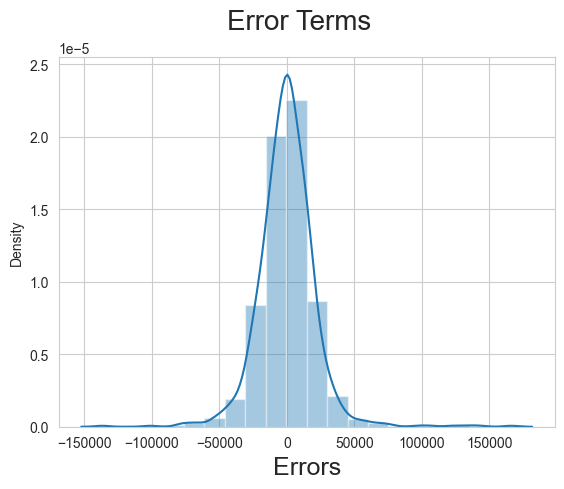

In [79]:

y_pred_train = lm.predict(X_train)

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

In [80]:
from sklearn.metrics import r2_score, mean_squared_error

def calculate_metrics(model):

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    metric = []
    r2_train_lr = r2_score(y_train, y_pred_train)
    print(f"Train R2 Score: {r2_train_lr:.4f}")
    metric.append(r2_train_lr)

    r2_test_lr = r2_score(y_test, y_pred_test)
    print(f"Test R2 Score: {r2_test_lr:.4f}")
    metric.append(r2_test_lr)

    rss1_lr = np.sum(np.square(y_train - y_pred_train))
    print(f"Train Residual Square Sum (RSS): {rss1_lr:.4f}")
    metric.append(rss1_lr)

    rss2_lr = np.sum(np.square(y_test - y_pred_test))
    print(F"Test Residual Square Sum (RSS): {rss2_lr:.4f}")
    metric.append(rss2_lr)

    mse_train_lr = mean_squared_error(y_train, y_pred_train)
    print(f"Train Mean Square Error: {mse_train_lr:.4f}")
    metric.append(mse_train_lr**0.5)

    mse_test_lr = mean_squared_error(y_test, y_pred_test)
    print(f"Test Mean Square Error: {mse_test_lr:.4f}")
    metric.append(mse_test_lr**0.5)

    return metric

In [81]:
metric1 = calculate_metrics(lm)

Train R2 Score: 0.9274
Test R2 Score: -28194741415608397824.0000
Train Residual Square Sum (RSS): 532005897126.0000
Test Residual Square Sum (RSS): 52929828202299596442014710759424.0000
Train Mean Square Error: 455484500.9640
Test Mean Square Error: 181266534939382179595940790272.0000


**Too much variance in R2 Score across train and test dataset.** The model is sensitive to predictor variables and could be overfitting to train data, needs regularization.

### Ridge and Lasso Regression

Lets predict sale price of house using Linear Regression ????

In [82]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [83]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 100}


In [84]:
# Fitting Ridge model for alpha and printing coefficients which have been penalised
alpha = 100
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-1.88998472e+02  2.07887069e+03  2.50083161e+03  6.42387269e+02
  6.71605912e+03  2.07950567e+03  1.11807763e+03  2.55638005e+02
  2.83056520e+03  6.20046191e+03  8.27359890e+03 -8.29271192e+02
  1.13579159e+04  3.56882583e+03  3.64462391e+02  3.43724904e+03
  2.75295852e+03 -2.44727626e+03 -2.25362325e+03  5.30593494e+03
  5.03346580e+03 -3.12119767e+03  7.18501228e+03  2.44530383e+03
  1.75491154e+03 -4.49953059e+02 -1.13613540e+02  1.16203119e+03
  1.21529865e+03 -6.17381037e+02  3.72567619e+01 -5.50484806e+02
 -8.53710424e+02 -2.06378635e+02 -5.58521875e+03 -1.71415733e+03
  1.37656597e+04  4.44062703e+03  5.76557817e+03 -1.22509195e+03
  0.00000000e+00 -2.75126566e+02  6.22299891e+03  3.38288814e+03
 -4.37149233e+02  1.10093254e+03  6.16752599e+03  3.45886899e+03
  2.71151128e+03  2.38165272e+03  1.39310157e+03 -5.47461363e+02
 -9.08791042e+02  3.37393373e+03 -1.41306969e+03  1.57662037e+03
  6.83967695e+02  1.50829672e+03 -2.35581509e+03 -4.77822952e+02
  4.77822952e+02 -6.63736

In [85]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
metric2 = calculate_metrics(ridge)

Train R2 Score: 0.8553
Test R2 Score: 0.8665
Train Residual Square Sum (RSS): 1060661450464.4491
Test Residual Square Sum (RSS): 250659060241.2703
Train Mean Square Error: 908100556.9045
Test Mean Square Error: 858421439.1824


### Lasso

In [86]:
from sklearn.linear_model import Lasso

lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [87]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 100}


In [88]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha=200

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=200)

In [89]:
lasso.coef_

array([ 0.00000000e+00,  2.49940058e+03,  5.04216830e+03,  0.00000000e+00,
        6.09460070e+03,  4.11224647e+03,  6.19034542e+02, -0.00000000e+00,
        2.78372617e+03,  0.00000000e+00,  8.49945174e+02, -1.95355293e+03,
        2.62872848e+04,  3.10311873e+03,  1.60910411e+02,  1.44305901e+03,
        1.24951891e+03, -3.05981202e+03, -2.13268793e+03,  3.48654474e+03,
        3.93611846e+03, -2.78891093e+03,  6.87788035e+03,  5.96014595e+02,
        1.08426895e+03,  0.00000000e+00, -4.02778312e+02,  9.21245735e+02,
        1.00184034e+03,  1.38312757e+03,  0.00000000e+00, -8.23765354e+02,
       -2.79650708e+02, -0.00000000e+00, -7.48460157e+03, -8.11907893e+02,
        1.32889019e+04,  5.40266078e+03,  4.70985682e+03, -1.27015873e+03,
        0.00000000e+00, -2.47438907e+02,  6.70829165e+03,  1.98919220e+03,
        0.00000000e+00,  7.78797326e+02,  5.44007659e+03,  3.40071498e+03,
        2.32169146e+03,  2.19527461e+03,  1.29422890e+03, -2.54100160e+02,
       -7.89288841e+02,  

In [90]:
metric3 = calculate_metrics(lasso)

Train R2 Score: 0.8901
Test R2 Score: 0.8822
Train Residual Square Sum (RSS): 805400256267.2523
Test Residual Square Sum (RSS): 221086042557.6219
Train Mean Square Error: 689555013.9274
Test Mean Square Error: 757143981.3617


In [91]:
# Creating a table which contain all the metrics
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric1
        }

lr_metric = pd.DataFrame(lr_table, columns = ['Metric', 'Linear Regression'] )
rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric.style.format(precision=3)

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.927,0.855,0.890
1,R2 Score (Test),-28194741415608397824.000,0.866,0.882
2,RSS (Train),532005897126.000,1060661450464.449,805400256267.252
3,RSS (Test),52929828202299596442014710759424.000,250659060241.270,221086042557.622
4,MSE (Train),21342.083,30134.707,26259.380
5,MSE (Test),425754078006755.188,29298.830,27516.249


## Lets observe the changes in the coefficients after regularization

In [92]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns

betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [93]:
pd.set_option('display.max_rows', None)
betas.sort_values(by='Lasso', ascending=False).head(250)

,Linear,Ridge,Lasso
cat__Neighborhood_NridgHt,2.984462e+14,9555.775957,31002.421221
cat__Neighborhood_NoRidge,2.984462e+14,8871.965455,30971.712342
num__GrLivArea,-1.285142e+16,11357.915920,26287.284783
cat__RoofMatl_WdShngl,3.745813e+14,3452.821645,20300.891985
cat__Neighborhood_StoneBr,2.984462e+14,3447.899946,17111.983710
cat__Neighborhood_Crawfor,2.984462e+14,5086.668401,15356.378951
cat__SaleType_New,2.258248e+15,3639.669269,13474.048629
num__OverallQual,9.982000e+03,13765.659732,13288.901901
cat__Condition1_Norm,-2.141627e+15,7380.563406,11386.767560
cat__Neighborhood_Somerst,2.984462e+14,1584.888114,8391.665707
